## MeLi Data Challenge 2019

This notebook is part of a curated version of my original solution for the MeLi Data Challenge hosted by [Mercado Libre](https://www.mercadolibre.com/) in 2019

The goal of this first challenge was to create a model that would classify items into categories based solely on the item’s title. 

This title is a free text input from the seller that would become the header of the listings.

<div class="alert alert-block alert-info">
<b>Note</b> <p>Only 10% of the data is used in the notebooks to improve the experience.</p>
    <p>Also, data is not being splitted by language in this notebooks for simplicity reasons only</p>
    <p>In the scripted version, 100% of the data is used to improve results</p>
</div>

### 2 - Train Model

In this notebook, we train a CNN using all the data created in the previous steps

### Import libraries

In [1]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
import copy
from tqdm.auto import tqdm
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, concatenate, Bidirectional, LSTM, MaxPooling1D, Activation, SpatialDropout1D
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, classification_report
import csv

### Load data

In [2]:
df = pd.read_pickle('./../data/df.pkl')
len_sent = joblib.load('./../data/len_sent.h5')

### Encode cateogories and save the references

In [3]:
nb_classes = len(np.unique(df['category']))
labels, levels = pd.factorize(df['category'])        
joblib.dump(nb_classes,'./../data/nb_classes')
joblib.dump(levels,'./../data/levels')

['./../data/levels']

### Split data 

We now split data into train and validation
<div class="alert alert-block alert-info">
<b>Note</b> <p>In <b>2- PreProcess</b> we also splitted the data in order to have a testing set</p>
</div>

In [4]:
train_df, val_df = train_test_split(df,test_size=0.1, stratify=df['category'])

### Data preparation steps
Here, we extract the values from the dataframes and generate the necessary encoded labels

In [5]:
y = copy.deepcopy(train_df['category'].values)
x = copy.deepcopy(train_df['input_data'].values)
y_val_in = copy.deepcopy(val_df['category'].values)
x_val_in = copy.deepcopy(val_df['input_data'].values)

In [6]:
x = np.stack(x)
x_val = np.stack(x_val_in)

In [7]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data, dtype=np.int16).reshape(-1)
    return np.eye(nb_classes,dtype=np.int8)[targets]

In [8]:
y = [np.where(levels == i)[0][0] for i in tqdm(y)]
y_val = [np.where(levels == i)[0][0] for i in tqdm(y_val_in)]

  0%|          | 0/161994 [00:00<?, ?it/s]

  0%|          | 0/18000 [00:00<?, ?it/s]

In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes = np.unique(y),
                                                 y = y)
class_weights = dict(zip(np.unique(y), class_weights))

In [10]:
y = indices_to_one_hot(y, nb_classes)
y_val = indices_to_one_hot(y_val, nb_classes)

### Define model

In [11]:
output_shape = y_val.shape[1]

In [12]:
def cnn_model(input_dim, output_shape, path=''):
    
    filter_sizes = [1, 2, 3, 4]
    num_filters = 200
    output_dim = 2000
    drop = 0.5
    
    weights = np.load(open(path+'/embeddings.npz', 'rb'))
    embedding_dim = weights.shape[1]
    
    inputs = Input(shape=(input_dim,), dtype='int32')
    
    embedding = Embedding(output_dim=weights.shape[1], input_dim=weights.shape[0], input_length=input_dim,
                              weights=[weights], trainable=True)(inputs)
                              
    spatial_dropout = SpatialDropout1D(0.5)(embedding)
        
    reshape = Reshape((input_dim, embedding_dim, 1))(spatial_dropout)

    conv_0 = Conv2D(num_filters, (filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal',
                           activation='sigmoid', data_format='channels_last')(reshape)
    conv_1 = Conv2D(num_filters, (filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal',
                           activation='sigmoid', data_format='channels_last')(reshape)
    conv_2 = Conv2D(num_filters, (filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal',
                           activation='sigmoid', data_format='channels_last')(reshape)
    conv_3 = Conv2D(num_filters, (filter_sizes[3], embedding_dim), padding='valid', kernel_initializer='normal',
                       activation='sigmoid', data_format='channels_last')(reshape)


    maxpool_0 = MaxPooling2D(pool_size=(input_dim - filter_sizes[0] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_0)
    maxpool_1 = MaxPooling2D(pool_size=(input_dim - filter_sizes[1] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_1)
    maxpool_2 = MaxPooling2D(pool_size=(input_dim - filter_sizes[2] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_2)
    maxpool_3 = MaxPooling2D(pool_size=(input_dim - filter_sizes[3] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_3)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3], axis=1)
    
    flatten = Flatten()(merged_tensor)
    
    #dense1 = Dense(units=output_dim, kernel_regularizer=regularizers.l2(0.01))(flatten)
    dense1 = Dense(units=output_dim)(flatten)
    #dense1 = BatchNormalization()(dense1)
    dense1 = Activation('relu')(dense1)
    dense1 = Dropout(drop)(dense1)

    #dense2 = Dense(units=output_dim, kernel_regularizer=regularizers.l2(0.01))(dense1)
    dense2 = Dense(units=output_dim)(dense1)
    #dense2 = BatchNormalization()(dense2)
    dense2 = Activation('relu')(dense2)
    dense2 = Dropout(drop)(dense2)

    #dense2 = Dense(units=output_dim, activation='relu')(dense1)
    #dense3 = Dense(units=output_dim, activation='relu')(dense2)
    output = Dense(units=output_shape)(dense1)
    #output = BatchNormalization()(output)
    output = Activation('softmax')(output)


    #output = Dense(units=output_shape, activation='softmax')(normalized_1)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

In [13]:
model = cnn_model(len_sent, output_shape, path='./../data')

In [14]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.save('./../data/my_model.h5')

In [15]:
checkpoint = ModelCheckpoint('./../data/weights.hdf5', monitor='val_accuracy', verbose=2,
                                             save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=6, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=2,verbose = 1)

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 24, 300)      1966500     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 24, 300)      0           embedding[0][0]                  
__________________________________________________________________________________________________
reshape (Reshape)               (None, 24, 300, 1)   0           spatial_dropout1d[0][0]          
_______________________________________________________________________________________

In [17]:
batch_size = 512
nb_epoch = 5
history = model.fit(x, y, batch_size=batch_size, epochs=nb_epoch, verbose=1,
                              callbacks=[checkpoint, early_stopping, reduceLR], 
                    validation_data=(x_val, y_val), class_weight=class_weights)

Epoch 1/5
317/317 [==============================] - ETA: 0s - loss: 7.3703 - accuracy: 7.5929e-04
Epoch 00001: val_accuracy improved from -inf to 0.00150, saving model to ./../data\weights.hdf5
317/317 [==============================] - 37s 117ms/step - loss: 7.3703 - accuracy: 7.5929e-04 - val_loss: 7.3461 - val_accuracy: 0.0015
Epoch 2/5
317/317 [==============================] - ETA: 0s - loss: 7.3504 - accuracy: 9.0127e-04
Epoch 00002: val_accuracy did not improve from 0.00150
317/317 [==============================] - 36s 115ms/step - loss: 7.3504 - accuracy: 9.0127e-04 - val_loss: 7.3473 - val_accuracy: 3.3333e-04
Epoch 3/5
317/317 [==============================] - ETA: 0s - loss: 7.3504 - accuracy: 8.6423e-04
Epoch 00003: val_accuracy did not improve from 0.00150

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.2999999166349884e-05.
317/317 [==============================] - 37s 115ms/step - loss: 7.3504 - accuracy: 8.6423e-04 - val_loss: 7.3477 - val_accuracy: 6.11

### Plot training

In [18]:
def plot_history(history, pref=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

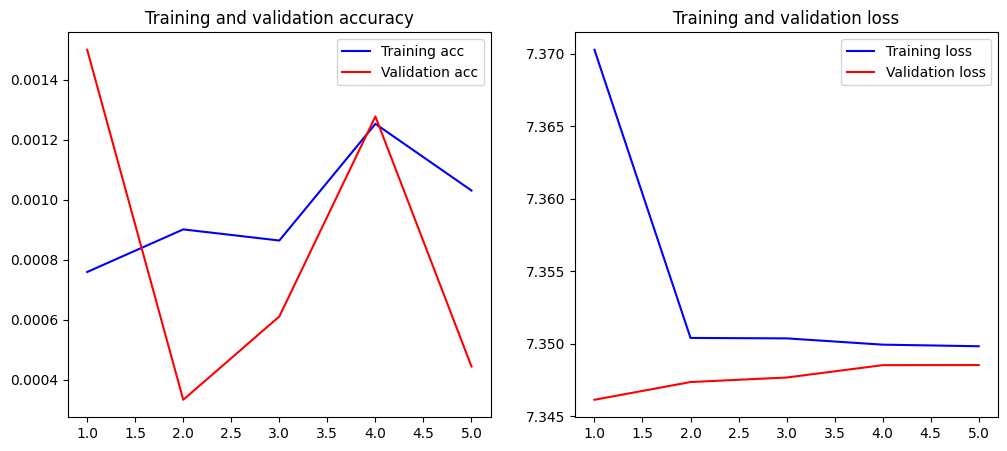

In [19]:
plot_history(history)

### Calculat BACC on Test Set

The metric used for evaluation in the challenge was Balanced Accuracy

In [20]:
df_test = pd.read_pickle('./../data/df_test.pkl')
xt = np.stack(df_test['input_data'])
outputs = model.predict(xt)

In [21]:
yt = [np.where(levels==i)[0][0] for i in df_test['category']]

In [22]:
yt = np.array(yt)

In [23]:
yt = indices_to_one_hot(yt, nb_classes)

In [24]:
bacc = balanced_accuracy_score(np.argmax(yt, axis=1), np.argmax(outputs, axis=1))

In [25]:
print(f"Bacc: {round(bacc*100, 2)}%")

Bacc: 0.11%


### Generate output file with predictions

In order to analyze how each class is performing, we print in a csv file some detailed information

This was used mostly to identify wordings specific to some classes that were replaced with generic tags using ReGex

In [26]:
def output_csv(y_true,y_pred,  orig_test, pad_test, language='spanish', path='', bacc = 0):
    levels = joblib.load('./../data/levels')
    csv_file = open('output_CNN.csv', 'w', newline='', encoding='utf-8')
    writer = csv.writer(csv_file)
    writer.writerow(
        ['Original','Padded','Human', 'Pred', 'Prob', 'BACC'])
    ix = 0
    cat_true = []
    cat_pred = []
    first = 0
    for y,h,o,p in zip(y_true,y_pred,orig_test, pad_test):
        cat_true.append(levels[np.argmax(y)])
        cat_pred.append(levels[np.argmax(h)])
        if first == 0:
            writer.writerow([o,p,levels[np.argmax(y)], levels[np.argmax(h)],h[np.argmax(h)],bacc])
            first = 1
        else:
            writer.writerow([o,p,levels[np.argmax(y)], levels[np.argmax(h)], h[np.argmax(h)]])
    report = classification_report(cat_true, cat_pred, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv('report.csv')

    csv_file.close()

In [27]:
output_csv(yt,outputs, df_test['title'].values, df_test['sentences_padded'].values, bacc = bacc)

c:\users\basla\documents\projects\bleandblog\bleandblog_posts\meli2019\meli2019\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\basla\documents\projects\bleandblog\bleandblog_posts\meli2019\meli2019\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\basla\documents\projects\bleandblog\bleandblog_posts\meli2019\meli2019\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

In [28]:
pd.read_csv('output_CNN.csv').head()

,Original,Padded,Human,Pred,Prob,BACC
0,Multi-capas Jjc 40.5mm Uv Filtro Filtro Ultrav...,"['multi', 'cap', 'jjc', '<smeasure>', 'uv', 'f...",LENS_FILTERS,LAPTOP_STANDS,0.000656,0.001051
1,Envase Plastico Rectangular Con Precinto En Ta...,"['envas', 'plastic', 'rectangul', 'precint', '...",PACKAGING_CONTAINERS,LAPTOP_STANDS,0.000658,NaN
2,Freezer Vertical 7 Cajones Acero Kohinoor Gsa2...,"['freez', 'vertical', '<number>', 'cajon', 'ac...",FREEZERS,LAPTOP_STANDS,0.000657,NaN
3,Tazas De Rueda Gol Gti 14\ Todos Los Modelos ...,"['taz', 'rued', 'gol', 'gti', '<number>', 'tod...",AUTOMOTIVE_WHEEL_COVERS,LAPTOP_STANDS,0.000657,NaN
4,Accesorios De Baño Porta Cepillo Dientes Fv Mi...,"['accesori', 'ban', 'port', 'cepill', 'dient',...",TOOTHBRUSH_HOLDERS,LAPTOP_STANDS,0.000660,NaN
